## Multinomial Choice Models and the Indepdence of Irrelevant Alternatives

In [1]:
import pandas as pd
import pymc as pm
import patsy
import numpy as np
import pytensor.tensor as pt
import arviz as az
import sys
sys.path.append('../../../..')

from pymc_marketing.customer_choice.mnl_logit import MNLogit

In [101]:
utility_formulas = ['gc ~ ic_gc + oc_gc | income + rooms + agehed', 
                    'gr ~ ic_gr + oc_gr | income + rooms + agehed', 
                    'ec ~ ic_ec + oc_ec | income + rooms + agehed', 
                    'er ~ ic_er + oc_er | income + rooms + agehed', 
                    'hp ~ ic_hp + oc_hp | income + rooms + agehed']


df = pd.read_csv('../../../../data/choice_wide_heating.csv')
df

,idcase,depvar,ic_gc,ic_gr,ic_ec,ic_er,ic_hp,oc_gc,oc_gr,oc_ec,oc_er,oc_hp,income,agehed,rooms,region
0,1,gc,866.00,962.64,859.90,995.76,1135.50,199.69,151.72,553.34,505.60,237.88,7,25,6,ncostl
1,2,gc,727.93,758.89,796.82,894.69,968.90,168.66,168.66,520.24,486.49,199.19,5,60,5,scostl
2,3,gc,599.48,783.05,719.86,900.11,1048.30,165.58,137.80,439.06,404.74,171.47,4,65,2,ncostl
3,4,er,835.17,793.06,761.25,831.04,1048.70,180.88,147.14,483.00,425.22,222.95,2,50,4,scostl
4,5,er,755.59,846.29,858.86,985.64,883.05,174.91,138.90,404.41,389.52,178.49,2,25,6,valley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,gc,766.39,877.71,751.59,869.78,942.70,142.61,136.21,474.48,420.65,203.00,6,20,4,mountn
896,897,gc,1128.50,1167.80,1047.60,1292.60,1297.10,207.40,213.77,705.36,551.61,243.76,7,45,7,scostl
897,898,gc,787.10,1055.20,842.79,1041.30,1064.80,175.05,141.63,478.86,448.61,254.51,5,60,7,scostl
898,899,gc,860.56,1081.30,799.76,1123.20,1218.20,211.04,151.31,495.20,401.56,246.48,5,50,6,scostl


In [12]:
mnl = MNLogit(df, utility_formulas, 'depvar', covariates=['ic', 'oc', 'income'])
mnl

In [13]:
mnl.model_config["likelihood"]

Prior("Categorical", p=0, dims="obs")

In [14]:
mnl.sample()

Sampling: [alphas_, betas, likelihood]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alphas_, betas]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Sampling: [likelihood]


Output()

In [15]:
mnl.idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [18]:
az.summary(mnl.idata, var_names=['alphas', 'betas'])

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alphas[gc],1.713,0.229,1.291,2.134,0.005,0.003,2026.0,2698.0,1.0
alphas[gr],0.310,0.205,-0.091,0.683,0.004,0.003,2256.0,2593.0,1.0
alphas[ec],1.629,0.439,0.718,2.376,0.010,0.008,1905.0,2045.0,1.0
alphas[er],1.831,0.356,1.149,2.481,0.008,0.006,1958.0,2196.0,1.0
alphas[hp],0.000,0.000,0.000,0.000,0.000,NaN,4000.0,4000.0,NaN
betas[ic],-0.002,0.001,-0.003,-0.000,0.000,0.000,2552.0,2815.0,1.0
betas[oc],-0.007,0.002,-0.010,-0.004,0.000,0.000,1841.0,2035.0,1.0
betas[income],-0.033,1.004,-1.880,1.859,0.017,0.016,3543.0,2683.0,1.0


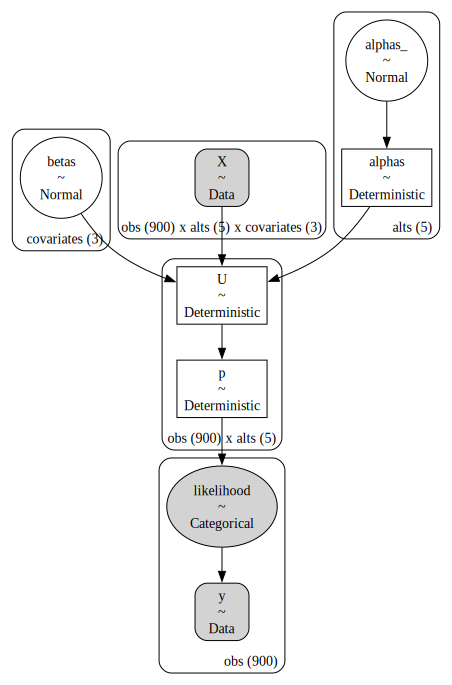

In [16]:
pm.model_to_graphviz(mnl.model)

In [6]:
az.summary(mnl.idata, var_names=['alphas', 'betas'])

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alphas[gc],1.715,0.227,1.282,2.122,0.005,0.004,1848.0,2106.0,1.00
alphas[gr],0.314,0.208,-0.060,0.714,0.005,0.003,1937.0,2373.0,1.00
alphas[ec],1.620,0.440,0.793,2.420,0.010,0.007,1759.0,2210.0,1.01
alphas[er],1.826,0.357,1.198,2.528,0.008,0.006,1885.0,2231.0,1.00
alphas[hp],0.000,0.000,0.000,0.000,0.000,NaN,4000.0,4000.0,NaN
betas[ic],-0.002,0.001,-0.003,-0.000,0.000,0.000,2640.0,2317.0,1.00
betas[oc],-0.007,0.002,-0.010,-0.004,0.000,0.000,1650.0,1856.0,1.00


In [103]:

def prepare_X_matrix(df, utility_formulas, depvar):
    """ Helper function to prepare a X matrix for utility equations
        The Dimensions of the X matrix should return a tensor
        with N observations x Alt x Covariates. Assumes utility
        formulas have an equal number of covariates per alternative. 
        These can be zero values if one alternative lacks some attribute.

        The utility formulas should express the driver relationship
        between the choice value in the dependent variable and the attributes
        of the alternative that would incentivise that choice. 
        The RHS of each formula needs to relate to a value of the dependent choice 
        variable and the LHS needs to express an additive relation of the available
        covariates
    """
    n_obs = len(df)
    n_alts = len(utility_formulas)
    n_covariates = len(utility_formulas[0].split('|')[0].split('+'))

    alts = []
    alt_covariates = []
    fixed_covariates = []
    for f in utility_formulas:
        split = f.split('~')
        covariates_split = split[1]
        fixed_covariates_split = covariates_split.split('|')
        f = '0 +' + fixed_covariates_split[0]
        alt_covariates.append(np.asarray(patsy.dmatrix(f, df)).T)
        alts.append(split[0].strip())
        if len(fixed_covariates_split) > 1:
            fixed_covariates.append(fixed_covariates_split[1])

    if fixed_covariates:  
        F = '+'.join(np.unique([fixed_covariates]))
        F = '0 + ' + F
        F = np.asarray(patsy.dmatrix(F, df))
    else:
        F = []
    

    X = np.stack(alt_covariates, axis=1).T
    assert X.shape == (n_obs, n_alts, n_covariates)
    for a in alts: 
        assert a in df[depvar].values

    return X, F, alts, np.unique(fixed_covariates)

X, F, alternatives, f_covariates = prepare_X_matrix(df, utility_formulas, 'depvar')

def prepare_y_outcome(df, alternatives, depvar):
    """ Helper function to categorically encode the outcome variable for
        use in the modelling. 

        The order of the alterntives should map to the order of the
        utility formulas. 
    """
    mode_mapping = dict(zip(alternatives, range(len(alternatives))))
    df['mode_encoded'] = df[depvar].map(mode_mapping)
    y = df['mode_encoded'].values
    return y

covariates = ['ic', 'oc']

y = prepare_y_outcome(df, alternatives, 'depvar')


def prepare_coords(df, alternatives, covariates, f_covariatess):
    coords = {
        "alts": alternatives,
        "alts_probs": alternatives[:-1],
        "alt_covariates": covariates,
        'fixed_covariates': [s.strip() for s in [s.split('+') for s in f_covariates][0]],
        "obs": range(len(df)),
    }
    return coords

coords = prepare_coords(df, alternatives, covariates, f_covariates)
coords

{'alts': ['gc', 'gr', 'ec', 'er', 'hp'],
 'alts_probs': ['gc', 'gr', 'ec', 'er'],
 'alt_covariates': ['ic', 'oc'],
 'fixed_covariates': ['income', 'rooms', 'agehed'],
 'obs': range(0, 900)}

In [104]:
F

array([[ 7.,  6., 25.],
       [ 5.,  5., 60.],
       [ 4.,  2., 65.],
       ...,
       [ 5.,  7., 60.],
       [ 5.,  6., 50.],
       [ 2.,  4., 65.]])

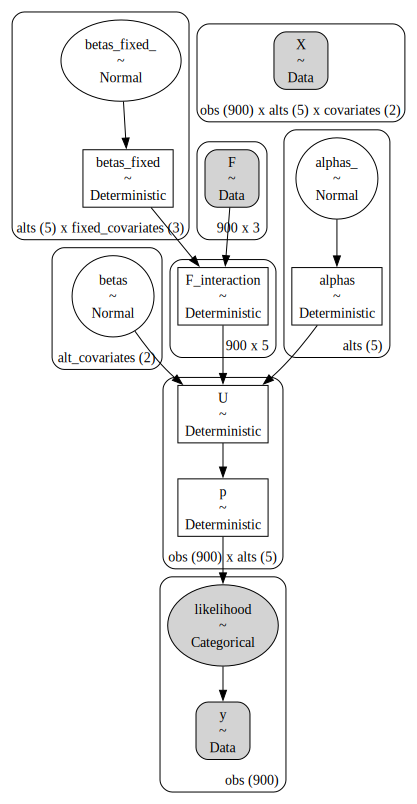

In [105]:
def make_model(X, y, coords, F=None):
    N = len(y)
    with pm.Model(coords=coords) as model:

        # Intercept Parameters
        alphas = pm.Normal('alphas_', 0,5, dims='alts')
        # Covariate Weight Parameters
        betas = pm.Normal('betas', 0, 1, dims=('alt_covariates'))
        if F is not None:
            betas_fixed_ = pm.Normal('betas_fixed_', 0, 1, dims=('alts','fixed_covariates'))
            betas_fixed = pm.Deterministic('betas_fixed', pt.set_subtensor(betas_fixed_[-1, :], 0), 
            dims=('alts','fixed_covariates'))
            F_data = pm.Data('F', F)
            F = pm.Deterministic('F_interaction', pm.math.dot(F_data, betas_fixed.T))
        else: 
            F = pt.zeros(N)


        # Instantiate covariate data for each Utility function
        X_data = pm.Data('X', X, dims=('obs', 'alts', 'covariates'))
        # Instantiate outcome data
        observed = pm.Data('y', y, dims='obs')

        # Compute utility as a dot product
        U = pm.math.dot(X, betas)  # (N, alts)
        # Zero out reference alternative intercept
        alphas = pm.Deterministic('alphas', pt.set_subtensor(alphas[-1], 0), 
        dims='alts')
        U = pm.Deterministic("U", F + U + alphas, dims=("obs", "alts"))
        ## Apply Softmax Transform
        p_ = pm.Deterministic("p", pm.math.softmax(U, axis=1), 
        dims=("obs", "alts"))
        ## Likelihood
        choice_obs = pm.Categorical("likelihood", p=p_, 
        observed=observed, dims="obs")
    
    return model

model = make_model(X, y, coords, F)
pm.model_to_graphviz(model)


In [106]:
with model: 
    idata_m1 = pm.sample_prior_predictive()
    idata_m1.extend(
        pm.sample(
        target_accept=.99,
        tune=2000,
        idata_kwargs={"log_likelihood": True}, 
        random_seed=101, 
        )
        )
    idata_m1.extend(pm.sample_posterior_predictive(idata_m1))

Sampling: [alphas_, betas, betas_fixed_, likelihood]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alphas_, betas, betas_fixed_]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 120 seconds.
Sampling: [likelihood]


Output()

In [107]:
az.summary(idata_m1, var_names=['betas', 'alphas', 'betas_fixed'])

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[ic],-0.002,0.001,-0.003,-0.000,0.000,0.000,4084.0,3145.0,1.0
betas[oc],-0.007,0.002,-0.010,-0.004,0.000,0.000,3242.0,2870.0,1.0
alphas[gc],1.391,0.714,0.089,2.759,0.021,0.013,1111.0,1880.0,1.0
alphas[gr],0.372,0.810,-1.135,1.917,0.024,0.015,1184.0,1656.0,1.0
alphas[ec],0.813,0.983,-0.978,2.715,0.025,0.016,1547.0,2307.0,1.0
alphas[er],2.349,0.882,0.710,4.037,0.024,0.014,1411.0,2169.0,1.0
alphas[hp],0.000,0.000,0.000,0.000,0.000,NaN,4000.0,4000.0,NaN
"betas_fixed[gc, income]",-0.065,0.085,-0.231,0.092,0.002,0.001,1480.0,2126.0,1.0
"betas_fixed[gc, rooms]",-0.003,0.082,-0.169,0.138,0.002,0.001,1389.0,1939.0,1.0
"betas_fixed[gc, agehed]",0.016,0.011,-0.005,0.036,0.000,0.000,1296.0,2193.0,1.0
